In [23]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [24]:
# ==============================
# IMPORT LIBRARIES
# ==============================
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap


In [25]:
# ==============================
# LOAD AND PREPROCESS DATA
# ==============================
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = df.drop(['customerID'], axis=1)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

# Handle missing values
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

# Map SeniorCitizen to Yes/No
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: "No", 1: "Yes"})

gender
Female    2544
Male      2619
Name: Churn, dtype: int64
gender
Female    939
Male      930
Name: Churn, dtype: int64


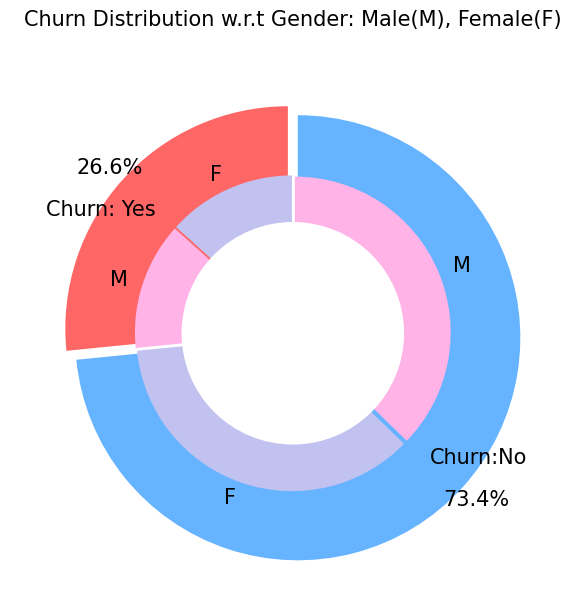

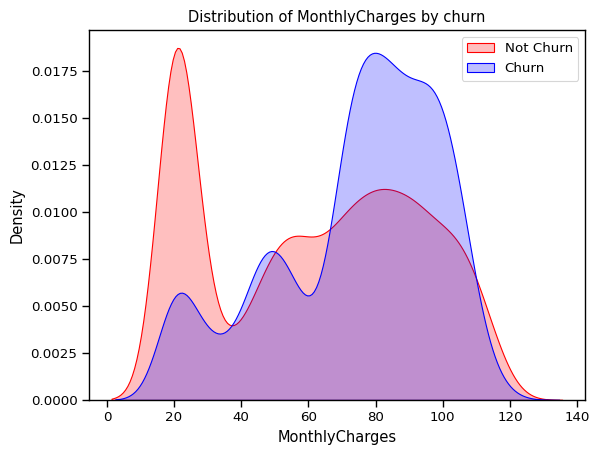

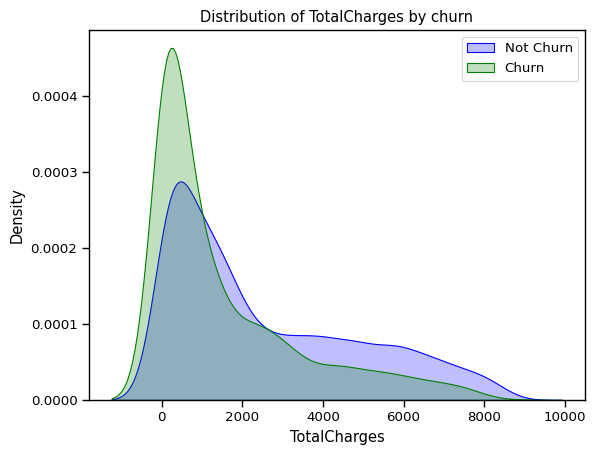

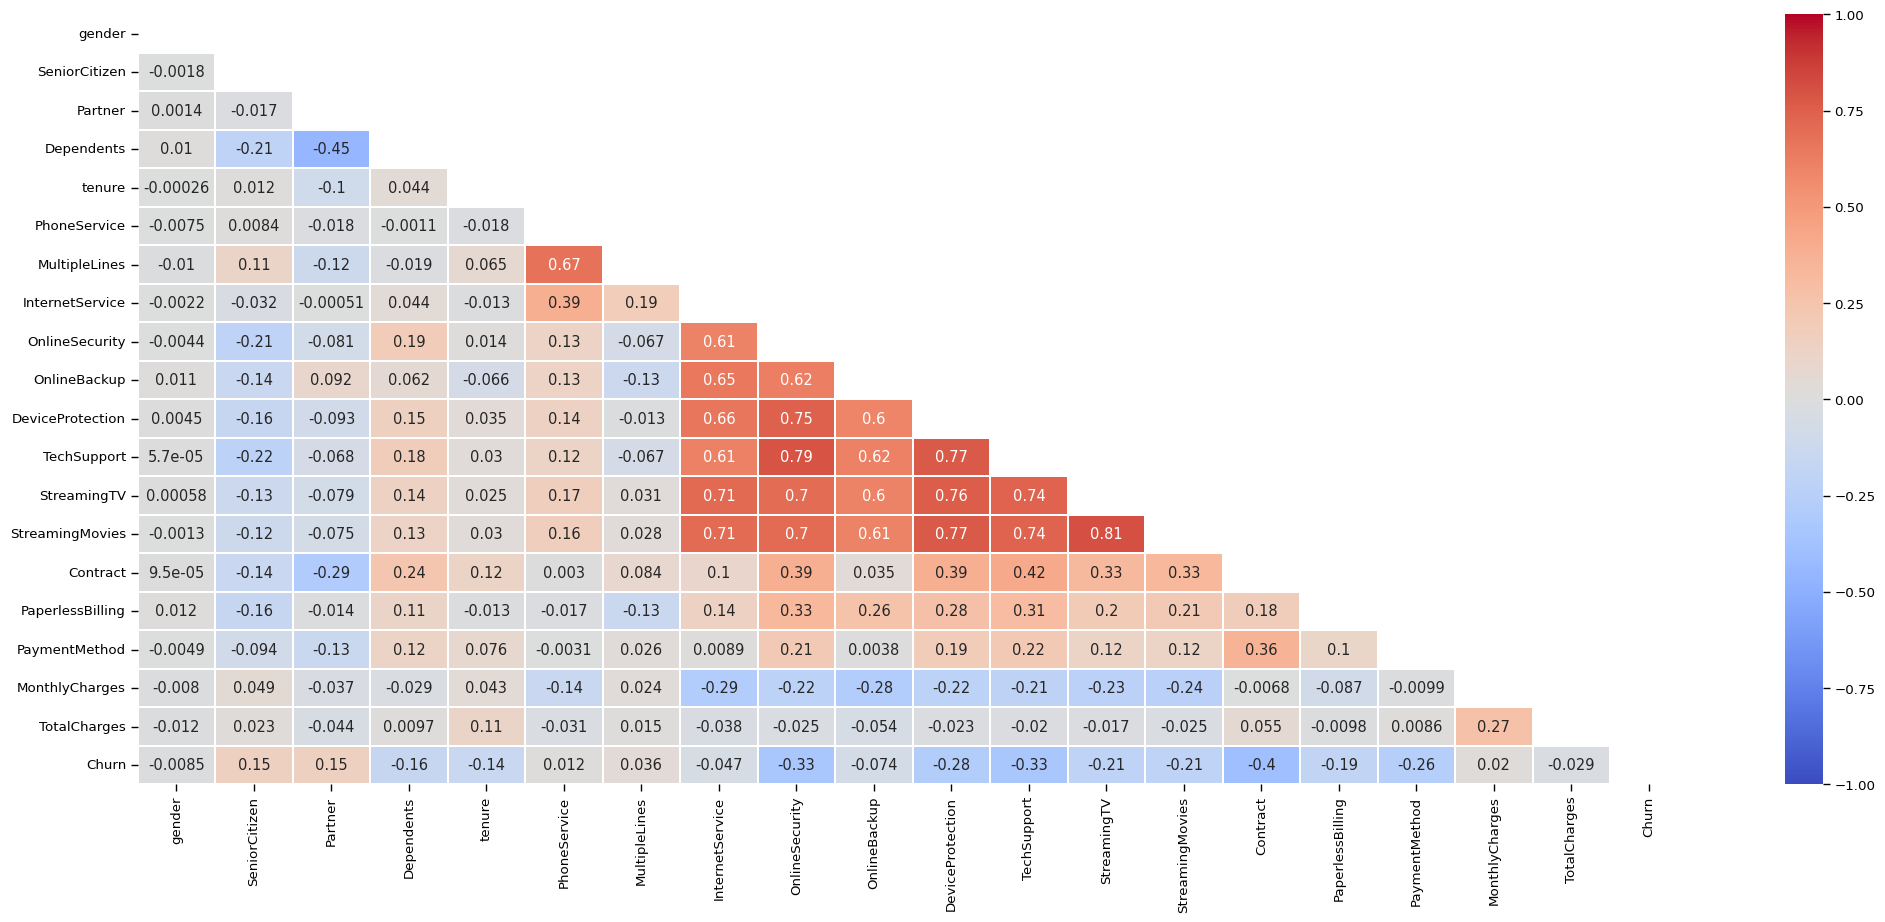

In [26]:
# ==============================
# DATA EXPLORATION
# ==============================
# Gender and Churn Pie Charts
g_labels = ['Male', 'Female']
c_labels = ['No', 'Yes']

fig = make_subplots(
    rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]]
)
fig.add_trace(go.Pie(labels=g_labels, values=df['gender'].value_counts(), name="Gender"), 1, 1)
fig.add_trace(go.Pie(labels=c_labels, values=df['Churn'].value_counts(), name="Churn"), 1, 2)
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)
fig.update_layout(
    title_text="Gender and Churn Distributions",
    annotations=[
        dict(text='Gender', x=0.16, y=0.5, font_size=20, showarrow=False),
        dict(text='Churn', x=0.84, y=0.5, font_size=20, showarrow=False)
    ]
)
fig.show()

# Gender-wise churn counts
print(df["Churn"][df["Churn"]=="No"].groupby(by=df["gender"]).count())
print(df["Churn"][df["Churn"]=="Yes"].groupby(by=df["gender"]).count())

# Combined Pie Chart: Churn w.r.t Gender
plt.figure(figsize=(6,6))
labels = ["Churn: Yes","Churn:No"]
values = [1869,5163]
labels_gender = ["F","M","F","M"]
sizes_gender = [939,930 , 2544,2619]
colors = ['#ff6666', '#66b3ff']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":15}

plt.pie(values, labels=labels, autopct='%1.1f%%', pctdistance=1.08,
        labeldistance=0.8, colors=colors, startangle=90, frame=True, explode=explode,
        radius=10, textprops=textprops, counterclock=True)
plt.pie(sizes_gender, labels=labels_gender, colors=colors_gender, startangle=90,
        explode=explode_gender, radius=7, textprops=textprops, counterclock=True)
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Contract Distribution vs Churn
fig = px.histogram(df, x="Churn", color="Contract", barmode="group", title="<b>Customer contract distribution</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

# Payment Method Distribution
fig = go.Figure(data=[go.Pie(labels=df['PaymentMethod'].unique(), values=df['PaymentMethod'].value_counts(), hole=.3)])
fig.update_layout(title_text="<b>Payment Method Distribution</b>")
fig.show()

# Payment Method vs Churn
fig = px.histogram(df, x="Churn", color="PaymentMethod", title="<b>Customer Payment Method distribution w.r.t. Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

# Internet Service vs Churn (Gender-wise)
fig = go.Figure()
services = ['DSL','Fiber optic','No Internet']
for service in services:
    fig.add_trace(go.Bar(
        x=[['Churn:No','Churn:No','Churn:Yes','Churn:Yes'],["Female","Male","Female","Male"]],
        y=df[df['InternetService']==service][["gender","Churn"]].value_counts().values,
        name=service
    ))
fig.update_layout(title_text="<b>Churn Distribution w.r.t. Internet Service and Gender</b>")
fig.show()

# Dependents, Partner, Senior Citizen, OnlineSecurity, PaperlessBilling, TechSupport, PhoneService distributions
color_maps = {
    "Dependents": {"Yes": "#FF97FF", "No": "#AB63FA"},
    "Partner": {"Yes": '#FFA15A', "No": '#00CC96'},
    "SeniorCitizen": {"Yes": '#00CC96', "No": '#B6E880'},
    "OnlineSecurity": {"Yes": "#FF97FF", "No": "#AB63FA"},
    "PaperlessBilling": {"Yes": '#FFA15A', "No": '#00CC96'},
    "PhoneService": {"Yes": '#00CC96', "No": '#B6E880'}
}

for col, cmap in color_maps.items():
    fig = px.histogram(df, x="Churn", color=col, barmode="group", title=f"<b>Churn distribution w.r.t. {col}</b>", color_discrete_map=cmap)
    fig.update_layout(width=700, height=500, bargap=0.1)
    fig.show()

# MonthlyCharges and TotalCharges distributions by Churn
sns.set_context("paper", font_scale=1.1)
for col, colors in zip(['MonthlyCharges','TotalCharges'], ['Red','Blue']):
    ax = sns.kdeplot(df[col][df['Churn']=='No'], color=colors, shade=True)
    ax = sns.kdeplot(df[col][df['Churn']=='Yes'], color='Green' if col=='TotalCharges' else 'Blue', shade=True)
    ax.legend(["Not Churn","Churn"], loc='upper right')
    ax.set_ylabel('Density')
    ax.set_xlabel(col)
    ax.set_title(f'Distribution of {col} by churn')
    plt.show()

# Tenure vs Churn Boxplot
fig = px.box(df, x='Churn', y='tenure', title='<b>Tenure vs Churn</b>')
fig.update_yaxes(title_text='Tenure (Months)')
fig.update_xaxes(title_text='Churn')
fig.update_layout(autosize=True, width=750, height=600, title_font=dict(size=25, family='Courier'))
fig.show()

# Correlation Heatmap
plt.figure(figsize=(25,10))
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [27]:
# ==============================
# FEATURE ENCODING
# ==============================
def object_to_int(series):
    if series.dtype == 'object':
        return LabelEncoder().fit_transform(series)
    return series

df = df.apply(lambda x: object_to_int(x))

In [28]:
# ==============================
# TRAIN-TEST SPLIT
# ==============================
X = df.drop(columns=['Churn'])
y = df['Churn'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify=y)

In [29]:
# ==============================
# STANDARDIZE NUMERICAL FEATURES
# ==============================
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

KNN Accuracy: 0.7758293838862559
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1549
           1       0.59      0.52      0.55       561

    accuracy                           0.78      2110
   macro avg       0.71      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110



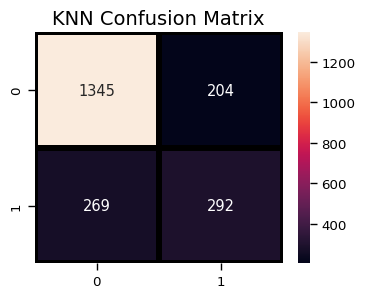

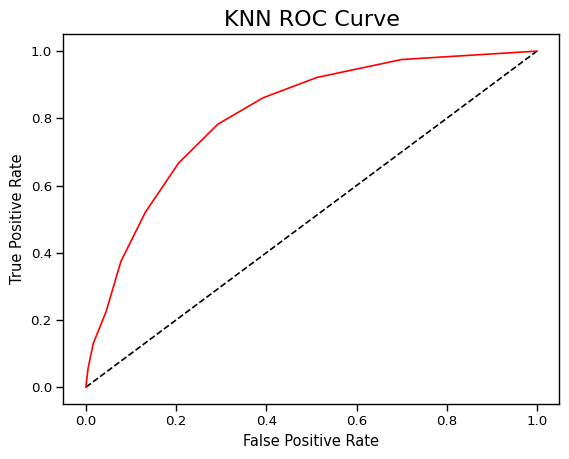



SVM Accuracy: 0.8075829383886256
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1549
           1       0.69      0.50      0.58       561

    accuracy                           0.81      2110
   macro avg       0.76      0.71      0.73      2110
weighted avg       0.80      0.81      0.80      2110



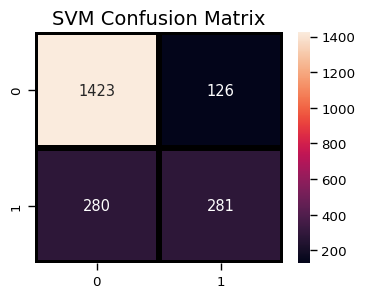

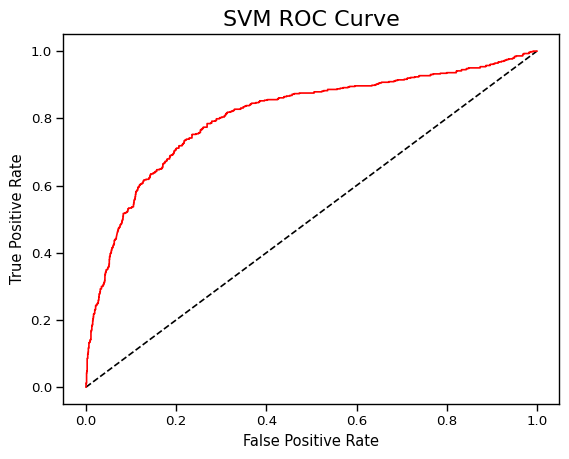



RandomForest Accuracy: 0.8137440758293839
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1549
           1       0.71      0.51      0.59       561

    accuracy                           0.81      2110
   macro avg       0.77      0.72      0.74      2110
weighted avg       0.80      0.81      0.80      2110



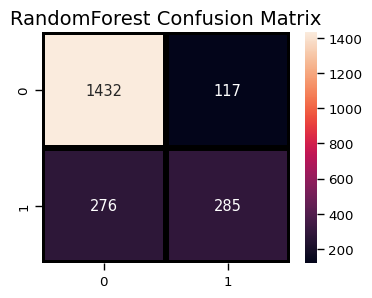

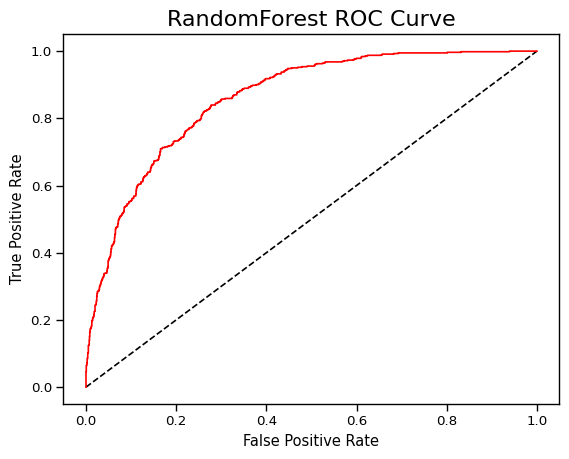



LogisticRegression Accuracy: 0.8090047393364929
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1549
           1       0.66      0.58      0.62       561

    accuracy                           0.81      2110
   macro avg       0.76      0.74      0.75      2110
weighted avg       0.80      0.81      0.80      2110



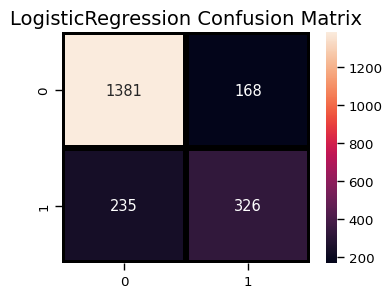

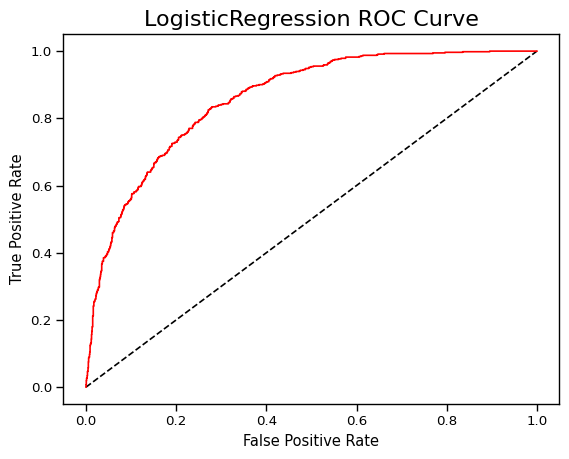



DecisionTree Accuracy: 0.7241706161137441
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1549
           1       0.48      0.52      0.50       561

    accuracy                           0.72      2110
   macro avg       0.65      0.66      0.65      2110
weighted avg       0.73      0.72      0.73      2110



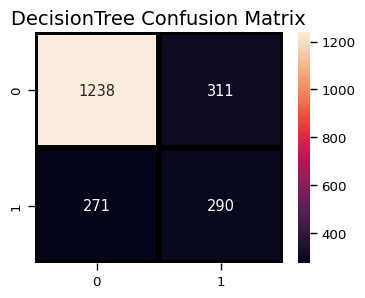

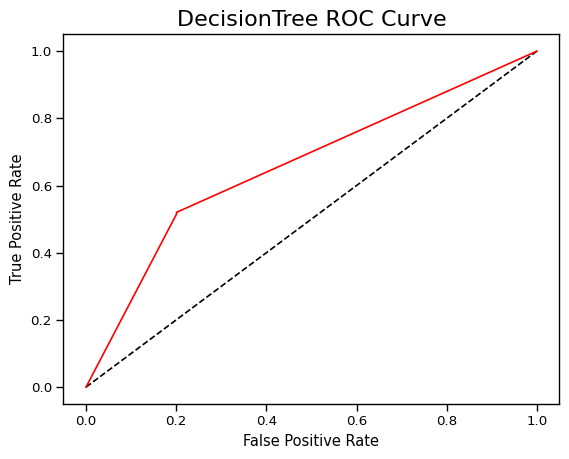



AdaBoost Accuracy: 0.8127962085308057
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1549
           1       0.68      0.56      0.62       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.75      2110
weighted avg       0.81      0.81      0.81      2110



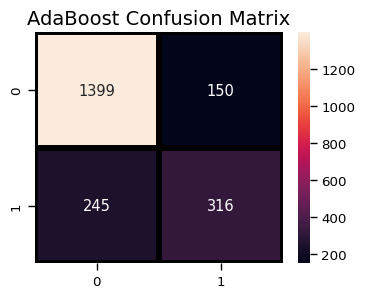

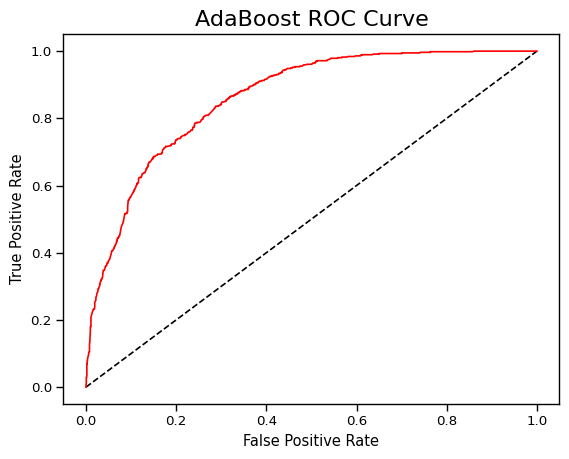



GradientBoosting Accuracy: 0.8080568720379147
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1549
           1       0.67      0.55      0.60       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110



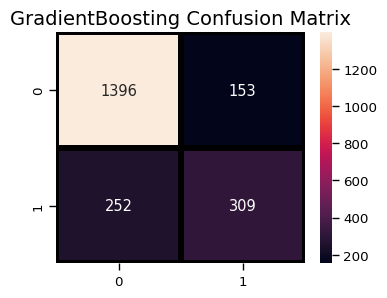

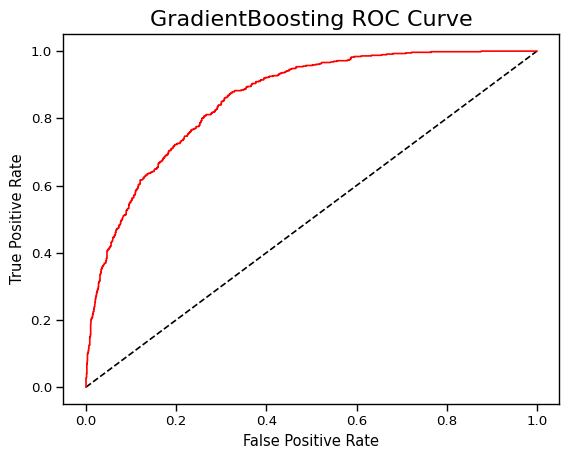

In [33]:
# ==============================
# MODELING
# ==============================
models = {
    "KNN": KNeighborsClassifier(n_neighbors=11),
    "SVM": SVC(random_state=1, probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=-1, random_state=50, max_features="sqrt", max_leaf_nodes=30),
    "LogisticRegression": LogisticRegression(),
    "DecisionTree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

# Train, predict and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc}")
    print(classification_report(y_test, preds))

    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d", linecolor="k", linewidths=3)
    plt.title(f"{name} Confusion Matrix", fontsize=14)
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=name, color='r')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{name} ROC Curve', fontsize=16)
        plt.show()

    print("\n")

Voting Classifier Accuracy: 0.8161137440758294
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1549
           1       0.68      0.57      0.62       561

    accuracy                           0.82      2110
   macro avg       0.77      0.74      0.75      2110
weighted avg       0.81      0.82      0.81      2110



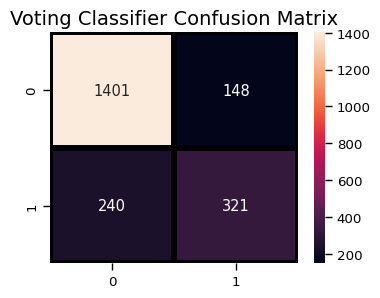

In [31]:
# ==============================
# VOTING CLASSIFIER
# ==============================
voting_model = VotingClassifier(estimators=[
    ('gbc', models['GradientBoosting']),
    ('lr', models['LogisticRegression']),
    ('abc', models['AdaBoost'])
], voting='soft')

voting_model.fit(X_train, y_train)
voting_preds = voting_model.predict(X_test)

print("Voting Classifier Accuracy:", accuracy_score(y_test, voting_preds))
print(classification_report(y_test, voting_preds))

plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, voting_preds), annot=True, fmt="d", linecolor="k", linewidths=3)
plt.title("Voting Classifier Confusion Matrix", fontsize=14)
plt.show()

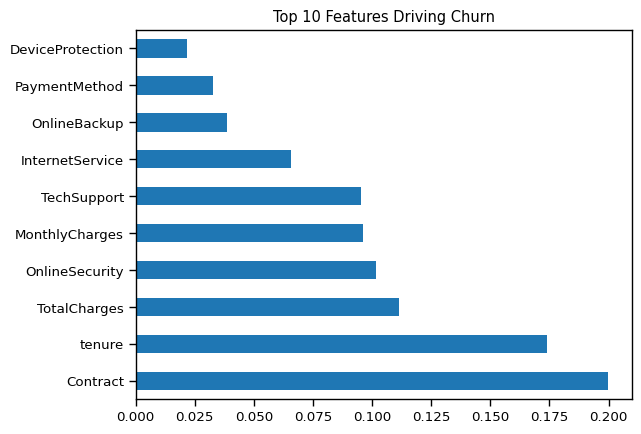

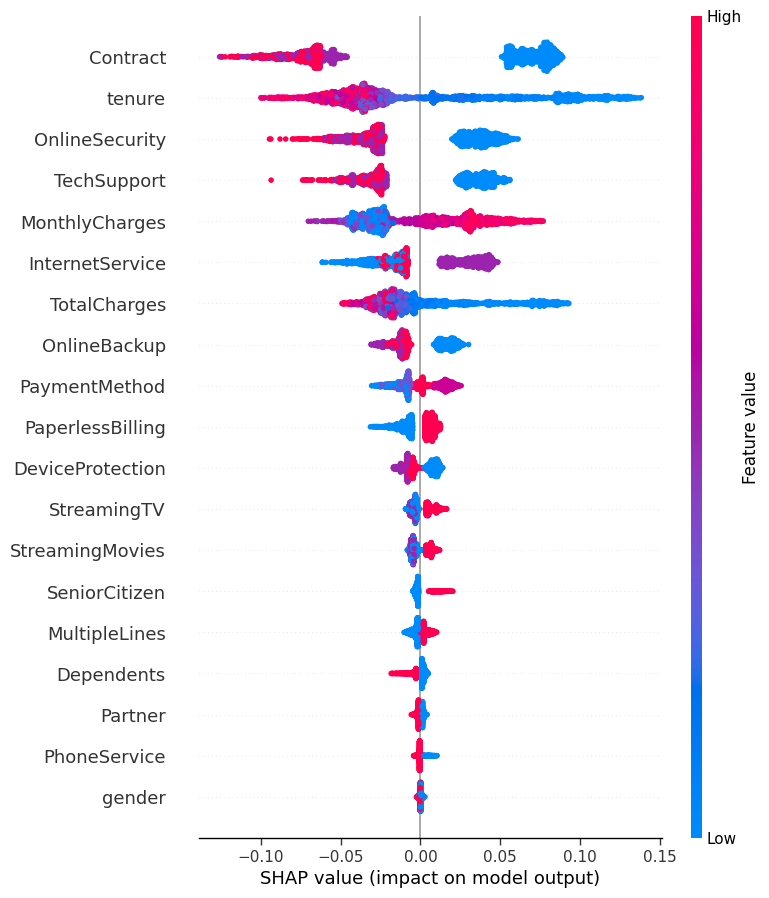

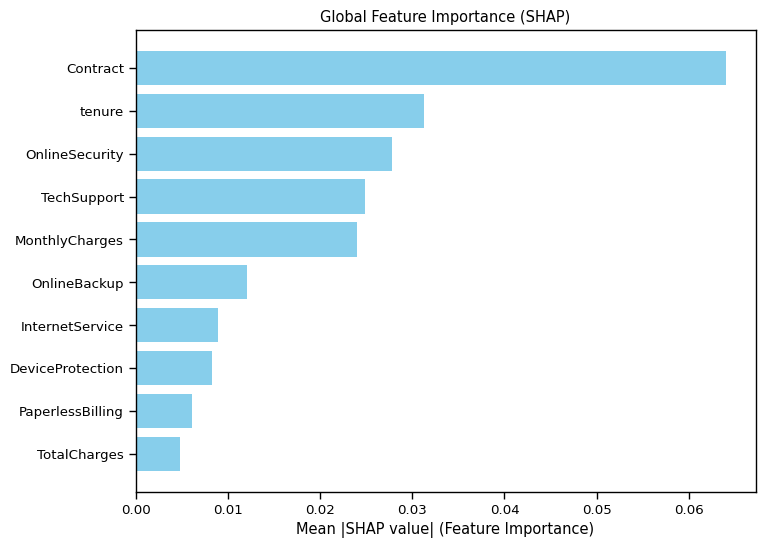

In [32]:
# ==============================
# FEATURE IMPORTANCE
# ==============================
# Random Forest Feature Importance
feature_importances = pd.Series(models['RandomForest'].feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Features Driving Churn")
plt.show()

# SHAP Analysis
explainer = shap.TreeExplainer(models['RandomForest'])
shap_values = explainer(X_test)
shap_yes = shap_values[...,1]  # positive class

shap.summary_plot(shap_yes, X_test, feature_names=X_test.columns)

# Global Feature Importance (SHAP)
shap_vals = shap_values[1].values
if shap_vals.shape[1] != X_test.shape[1]:
    shap_vals = shap_vals.T

importance_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance": np.abs(shap_vals).mean(axis=0)
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(importance_df["feature"].head(10), importance_df["importance"].head(10), color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Mean |SHAP value| (Feature Importance)")
plt.title("Global Feature Importance (SHAP)")
plt.show()